In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler

In [8]:
df = pd.read_csv('../data/zillow_data.csv')
df

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14718,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,94600.0,94300.0,94000.0,...,216800,217700,218600,218500,218100,216400,213100,209800,209200,209300
14719,59107,3293,Woodstock,NH,Claremont,Grafton,14720,92700.0,92500.0,92400.0,...,202100,208400,212200,215200,214300,213100,213700,218300,222700,225800
14720,75672,40404,Berea,KY,Richmond,Madison,14721,57100.0,57300.0,57500.0,...,121800,122800,124600,126700,128800,130600,131700,132500,133000,133400
14721,93733,81225,Mount Crested Butte,CO,NaN,Gunnison,14722,191100.0,192400.0,193700.0,...,662800,671200,682400,695600,695500,694700,706400,705300,681500,664400


In [9]:
df_time_series = pd.DataFrame(index=pd.to_datetime(df.columns[7:]), data=np.ones(len(df.columns)-7))
for i in range(df.shape[0]):
    df_time_series[df['RegionID'][i]] = df.iloc[i,7:]
df_time_series.drop(df_time_series.columns[0],axis=1, inplace=True)
df_time_series

,84654,90668,91982,84616,93144,91733,61807,84640,91940,97564,...,59187,94711,62556,99032,62697,58333,59107,75672,93733,95851
1996-04-01,334200,235700,210400,498100,77300,95000,152900,216500,95400,766000,...,80800,135900,78300,136200,62500,94600,92700,57100,191100,176400
1996-05-01,335400,236900,212200,500900,77300,95200,152700,216700,95600,771100,...,80100,136300,78300,136600,62600,94300,92500,57300,192400,176300
1996-06-01,336500,236700,212200,503100,77300,95400,152600,216900,95800,776500,...,79400,136600,78200,136800,62700,94000,92400,57500,193700,176100
1996-07-01,337600,235400,210700,504600,77300,95700,152400,217000,96100,781900,...,78600,136900,78200,136800,62700,93700,92200,57700,195000,176000
1996-08-01,338500,233300,208300,505500,77400,95900,152300,217100,96400,787300,...,77900,137100,78100,136700,62700,93400,92100,58000,196300,175900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-01,1018700,316600,321200,1299000,120300,162800,414300,777900,172300,3778700,...,123400,257600,171300,341000,122800,216400,213100,130600,694700,348900
2018-01-01,1024400,318100,321200,1302700,120300,162800,413900,778500,173300,3770800,...,124400,258000,172400,342300,123200,213100,213700,131700,706400,350400
2018-02-01,1030700,319600,323000,1306400,120500,162900,411400,780500,174200,3763100,...,125500,260600,173600,345000,123200,209800,218300,132500,705300,353000
2018-03-01,1033800,321100,326900,1308500,121000,163500,413200,782800,175400,3779800,...,126600,264700,175800,348000,120700,209200,222700,133000,681500,356000


In [10]:
df_time_series.isna().sum().sum()

156891

In [11]:
df_nv = df[df['State'] == 'NV']
nv_zipcodes = list(df_nv.RegionID)
nv_zipcodes[0]

95804

In [12]:
df_time_series.fillna(method='bfill', inplace=True)

In [13]:
df_time_series.isna().sum().sum()

0

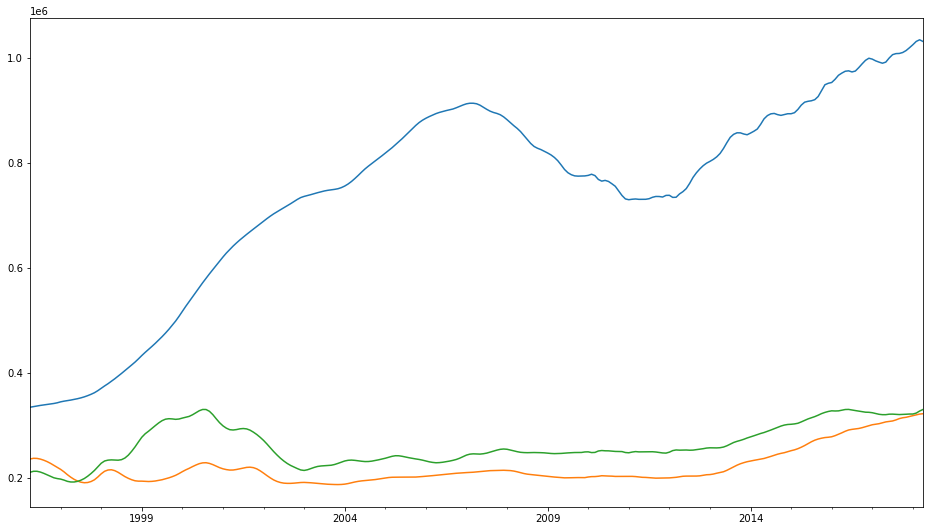

In [14]:
df_time_series.iloc[:,0].plot(figsize=(16,9))
df_time_series.iloc[:,1].plot()
df_time_series.iloc[:,2].plot();

# RNN Model

In [15]:
size = int(len(df_time_series)*.8)
train = df_time_series.iloc[:size]
test = df_time_series.iloc[size:]

In [16]:
df_time_series = df_time_series[nv_zipcodes]
train = train[nv_zipcodes]
test = test[nv_zipcodes]

We are trying a RNN model to see how it does on our first zipcode

In [17]:
x = 0
train_data = train.iloc[:,x:x+1].values.astype(int)
test_data = test.iloc[:,x:x+1].values.astype(int)

In [18]:
scaler = MinMaxScaler(feature_range=(0,1))
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.fit_transform(test_data)

Creating a dataset with 60 timesteps (5 years)

In [19]:
X_train = []
y_train = []
for i in range(60,len(train_data_scaled)):
    X_train.append(train_data_scaled[i-60:i])
    y_train.append(train_data_scaled[i])

data_total = pd.concat((train.iloc[:,x:x+1], test.iloc[:,x:x+1]),axis=0)
inputs = data_total[len(train)-60:].values
inputs = scaler.transform(inputs)

X_test = []
y_test = []
for i in range(60,len(inputs)):
    X_test.append(inputs[i-60:i])
    y_test.append(inputs[i])
X_test = np.array(X_test)
y_test = np.array(test_data)

Turn data into arrays for RNN

In [20]:
X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

Initialize RNN Model

In [21]:
rnn_model = Sequential()

Building the LSTM layers

In [22]:
rnn_model.add(LSTM(units= 60, return_sequences = False, input_shape=((60,1))))


In [23]:
rnn_model.add(Dense(units=1))


In [24]:
rnn_model.compile(optimizer='adam', loss='mean_squared_error')

In [25]:
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60)                14880     
_________________________________________________________________
dense (Dense)                (None, 1)                 61        
Total params: 14,941
Trainable params: 14,941
Non-trainable params: 0
_________________________________________________________________


In [26]:
rnn_model.fit(X_train, y_train, epochs=100, batch_size=32)


Epoch 1/100
5/5 [==============================] - 0s 13ms/step - loss: 0.2913
Epoch 2/100
5/5 [==============================] - 0s 11ms/step - loss: 0.1091
Epoch 3/100
5/5 [==============================] - 0s 11ms/step - loss: 0.0371
Epoch 4/100
5/5 [==============================] - 0s 10ms/step - loss: 0.0362
Epoch 5/100
5/5 [==============================] - 0s 10ms/step - loss: 0.0174
Epoch 6/100
5/5 [==============================] - 0s 10ms/step - loss: 0.0178
Epoch 7/100
5/5 [==============================] - 0s 10ms/step - loss: 0.0159
Epoch 8/100
5/5 [==============================] - 0s 11ms/step - loss: 0.0113
Epoch 9/100
5/5 [==============================] - 0s 10ms/step - loss: 0.0100
Epoch 10/100
5/5 [==============================] - 0s 13ms/step - loss: 0.0087
Epoch 11/100
5/5 [==============================] - 0s 10ms/step - loss: 0.0069
Epoch 12/100
5/5 [==============================] - 0s 11ms/step - loss: 0.0061
Epoch 13/100
5/5 [==============================]

In [27]:
y_hat_raw = rnn_model.predict(X_test)
y_hat = scaler.inverse_transform(y_hat_raw)

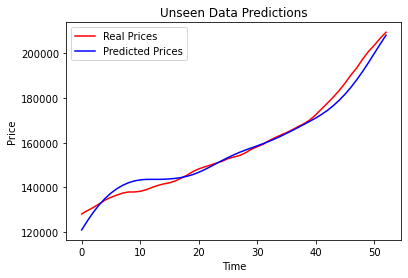

In [28]:
plt.plot(y_test, color='red', label='Real Prices')
plt.plot(y_hat, color='blue', label='Predicted Prices')
plt.title('Unseen Data Predictions')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show;

Using Our RNN model on all NV Zipcodes

In [29]:
zipcodes = nv_zipcodes
dict_mape = {}
dict_pred = {}

for zipcode in range(len(zipcodes)):

    # init a RMM model
    rnn_model = Sequential()
    # add 4 layers of RNN and a last layer

    # we define shape on first layer, (60,1) because we use 60 inputs per prediction
    rnn_model.add(LSTM(units= 60, return_sequences = False, input_shape=((60,1))))
    #rnn_model.add(Dropout(.1))

    # 3 other layers
    #rnn_model.add(LSTM(units= 30, return_sequences = True))
    #rnn_model.add(Dropout(.1))

    # return_sequence is False because we want only 1 output after this layer
    #rnn_model.add(LSTM(units= 60, return_sequences = False))
    #rnn_model.add(Dropout(.1))

    # last layer 

    rnn_model.add(Dense(units=1))

    # compile - because this is a regression model we want to minimize MSE

    rnn_model.compile(optimizer='adam', loss='mean_absolute_percentage_error')

    # We get only the specific column(Zipcode from our train and test datas)
    train_data = train.iloc[:,zipcode:zipcode+1].values.astype(int)
    test_data = test.iloc[:,zipcode:zipcode+1].values.astype(int)
    
    # We are using normalizaion rather than standascaler. 
    # In a upward trending timeseries it is better to not start from negative

    scaler = MinMaxScaler(feature_range=(0,1))
    train_data_scaled = scaler.fit_transform(train_data)
    test_data_scaled = scaler.transform(test_data)

    # Because we are using 60 previous values to model and predict the next value, 
    # We set X_train from arrays of 60 for each y_train value
    # Same idea for test data sets
    X_train = []
    y_train = []
    for i in range(60,len(train_data_scaled)):
        X_train.append(train_data_scaled[i-60:i])
        y_train.append(train_data_scaled[i])

    data_total = pd.concat((train.iloc[:,zipcode:zipcode+1], test.iloc[:,zipcode:zipcode+1]),axis=0)
    inputs = data_total[len(train)-60:].values
    inputs = scaler.transform(inputs)

    X_test = []
    y_test = []
    for i in range(60,len(inputs)):
        X_test.append(inputs[i-60:i])
        y_test.append(inputs[i])
    X_test = np.array(X_test)
    y_test = np.array(test_data)

    # We need numpy arrays for our model
    X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)
    
    # We fit our data to our zipcode specific data
    rnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, scaler.transform(y_test)))

    # Make predictions on the data

    y_hat_raw = rnn_model.predict(X_test)
    y_hat = scaler.inverse_transform(y_hat_raw)

    # Use the score on unseen test data to calculate the MAPE

    dict_mape[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_test)/y_test))      

    # We get the last 60 values from our test data which is basically last 60 values in the data set
    last_60 = df_time_series.iloc[-60:,zipcode:zipcode+1].values.astype(int)
    
    # Before we use our data we scale it
    last_60 = scaler.transform(last_60)
    
    # Our input should be in (x,60,1) format
    x_new_pred = last_60[-60:].reshape(1,60,1)

    # make a prediction, add to the last_60 for the next prediction and 
    y_pred = rnn_model.predict(x_new_pred)

    # We add our predition to our list of predictions for zipcode specific predictions list
    dict_pred[zipcodes[zipcode]]=scaler.inverse_transform(y_pred)
    
    print(f'Iteration number {zipcode} finished')
    

Epoch 1/50
5/5 [==============================] - 0s 98ms/step - loss: 13344.6377 - val_loss: 88.9842
Epoch 2/50
5/5 [==============================] - 0s 16ms/step - loss: 287148.1250 - val_loss: 88.1756
Epoch 3/50
5/5 [==============================] - 0s 16ms/step - loss: 220756.1875 - val_loss: 94.9052
Epoch 4/50
5/5 [==============================] - 0s 16ms/step - loss: 48676.0234 - val_loss: 99.3483
Epoch 5/50
5/5 [==============================] - 0s 15ms/step - loss: 2735.2988 - val_loss: 105.4793
Epoch 6/50
5/5 [==============================] - 0s 15ms/step - loss: 177464.5000 - val_loss: 107.8158
Epoch 7/50
5/5 [==============================] - 0s 15ms/step - loss: 161273.7188 - val_loss: 106.7928
Epoch 8/50
5/5 [==============================] - 0s 17ms/step - loss: 127502.5938 - val_loss: 102.9215
Epoch 9/50
5/5 [==============================] - 0s 16ms/step - loss: 46896.5625 - val_loss: 99.2472
Epoch 10/50
5/5 [==============================] - 0s 16ms/step - loss: 62

In [30]:
rnn_keys = list(dict_mape.keys())
rnn_mape = list(dict_mape.values())
rnn_pred = []
rnn_dict = {}
for zipcode in dict_pred.keys():
    rnn_pred.append(dict_pred[zipcode].astype(int)[0][0])
for zc in rnn_keys:
    a = []
    a.append(dict_mape[zc])
    a.append(dict_pred[zc].astype(float)[0][0])
    a.append('RNN')
    rnn_dict[zc] = a

In [31]:
rnn_dict

{95804: [0.5159191513365095, 75412.6796875, 'RNN'],
 95817: [0.4806917270953116, 82854.0859375, 'RNN'],
 95813: [0.013083894437494591, 341304.875, 'RNN'],
 95785: [0.01378739311178748, 422513.25, 'RNN'],
 95819: [0.015094171486925623, 301021.0625, 'RNN'],
 95770: [0.44194695282497615, 105605.78125, 'RNN'],
 95806: [0.5182788597996814, 70026.3359375, 'RNN'],
 95790: [0.007388430655138559, 312865.75, 'RNN'],
 95799: [0.41473107013635707, 110862.84375, 'RNN'],
 95844: [0.014626261526478987, 297665.53125, 'RNN'],
 95843: [0.40972854999398295, 126288.140625, 'RNN'],
 95815: [0.4957810488444431, 84689.921875, 'RNN'],
 95825: [0.38387902090114595, 142043.46875, 'RNN'],
 95818: [0.4386295986242681, 94474.0703125, 'RNN'],
 95811: [0.46491245082909255, 74676.609375, 'RNN'],
 95931: [0.44696939316482326, 114605.4375, 'RNN'],
 95753: [0.3965936438523714, 141604.265625, 'RNN'],
 95827: [0.007951250432951461, 335392.75, 'RNN'],
 95937: [0.010482319800557482, 444971.84375, 'RNN'],
 95914: [0.43587610

In [32]:
np.mean(rnn_mape)

0.201744244348875

In [33]:
zipcodes = nv_zipcodes
dict_mape2 = {}
dict_pred2 = {}

for zipcode in range(len(zipcodes)):

    # init a RMM model
    rnn_model2 = Sequential()
    # add 4 layers of RNN and a last layer

    # we define shape on first layer, (60,1) because we use 60 inputs per prediction
    rnn_model2.add(LSTM(units= 60, return_sequences = True, input_shape=((60,1))))
    #rnn_model.add(Dropout(.1))

    # another layer
    rnn_model2.add(LSTM(units= 30, return_sequences = False))
    #rnn_model.add(Dropout(.1))

    # return_sequence is False because we want only 1 output after this layer
    #rnn_model.add(LSTM(units= 60, return_sequences = False))
    #rnn_model.add(Dropout(.1))

    # last layer 

    rnn_model2.add(Dense(units=1))

    # compile - because this is a regression model we want to minimize MSE

    rnn_model2.compile(optimizer='adam', loss='mean_absolute_percentage_error')

    # We get only the specific column(Zipcode from our train and test datas)
    train_data = train.iloc[:,zipcode:zipcode+1].values.astype(int)
    test_data = test.iloc[:,zipcode:zipcode+1].values.astype(int)
    
    # We are using normalizaion rather than standascaler. 
    # In a upward trending timeseries it is better to not start from negative

    scaler = MinMaxScaler(feature_range=(0,1))
    train_data_scaled = scaler.fit_transform(train_data)
    test_data_scaled = scaler.transform(test_data)

    # Because we are using 60 previous values to model and predict the next value, 
    # We set X_train from arrays of 60 for each y_train value
    # Same idea for test data sets
    X_train = []
    y_train = []
    for i in range(60,len(train_data_scaled)):
        X_train.append(train_data_scaled[i-60:i])
        y_train.append(train_data_scaled[i])

    data_total = pd.concat((train.iloc[:,zipcode:zipcode+1], test.iloc[:,zipcode:zipcode+1]),axis=0)
    inputs = data_total[len(train)-60:].values
    inputs = scaler.transform(inputs)

    X_test = []
    y_test = []
    for i in range(60,len(inputs)):
        X_test.append(inputs[i-60:i])
        y_test.append(inputs[i])
    X_test = np.array(X_test)
    y_test = np.array(test_data)

    # We need numpy arrays for our model
    X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)
    
    # We fit our data to our zipcode specific data
    rnn_model2.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, scaler.transform(y_test)))

    # Make predictions on the data

    y_hat_raw = rnn_model2.predict(X_test)
    y_hat = scaler.inverse_transform(y_hat_raw)

    # Use the score on unseen test data to calculate the MAPE

    dict_mape2[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_test)/y_test))      

    # We get the last 60 values from our test data which is basically last 60 values in the data set
    last_60 = df_time_series.iloc[-60:,zipcode:zipcode+1].values.astype(int)
    
    # Before we use our data we scale it
    last_60 = scaler.transform(last_60)
    
    # Our input should be in (x,60,1) format
    x_new_pred = last_60[-60:].reshape(1,60,1)

    # make a prediction, add to the last_60 for the next prediction and 
    y_pred = rnn_model2.predict(x_new_pred)

    # We add our predition to our list of predictions for zipcode specific predictions list
    dict_pred2[zipcodes[zipcode]]=scaler.inverse_transform(y_pred)
    
    print(f'Iteration number {zipcode} finished')
    

Epoch 1/50
5/5 [==============================] - 1s 133ms/step - loss: 8016.3657 - val_loss: 116.9793
Epoch 2/50
5/5 [==============================] - 0s 26ms/step - loss: 289439.8438 - val_loss: 114.8002
Epoch 3/50
5/5 [==============================] - 0s 26ms/step - loss: 171865.0781 - val_loss: 109.7558
Epoch 4/50
5/5 [==============================] - 0s 26ms/step - loss: 67592.4609 - val_loss: 103.9603
Epoch 5/50
5/5 [==============================] - 0s 26ms/step - loss: 92420.1016 - val_loss: 101.8322
Epoch 6/50
5/5 [==============================] - 0s 26ms/step - loss: 82672.1484 - val_loss: 102.9477
Epoch 7/50
5/5 [==============================] - 0s 26ms/step - loss: 7458.7935 - val_loss: 104.3932
Epoch 8/50
5/5 [==============================] - 0s 28ms/step - loss: 56210.8750 - val_loss: 104.0278
Epoch 9/50
5/5 [==============================] - 0s 28ms/step - loss: 56789.8086 - val_loss: 102.5874
Epoch 10/50
5/5 [==============================] - 0s 26ms/step - loss: 

In [34]:
rnn_keys2 = list(dict_mape2.keys())
rnn_mape2 = list(dict_mape2.values())
rnn_pred2 = []
rnn_dict2 = {}
for zipcode in dict_pred.keys():
    rnn_pred2.append(dict_pred2[zipcode].astype(int)[0][0])
for zc in rnn_keys2:
    a = []
    a.append(dict_mape2[zc])
    a.append(dict_pred2[zc].astype(float)[0][0])
    a.append('RNN_2_Layers')
    rnn_dict2[zc] = a

In [35]:
np.mean(rnn_mape2)

0.2113528638887323

In [36]:
zipcodes = nv_zipcodes
dict_mape3 = {}
dict_pred3 = {}

for zipcode in range(len(zipcodes)):

    # init a RMM model
    rnn_model = Sequential()
    # add 4 layers of RNN and a last layer

    # we define shape on first layer, (60,1) because we use 60 inputs per prediction
    rnn_model.add(LSTM(units= 60, return_sequences = False, input_shape=((60,1))))
    rnn_model.add(Dropout(.1))

    # 3 other layers
    #rnn_model.add(LSTM(units= 30, return_sequences = True))
    #rnn_model.add(Dropout(.1))

    # return_sequence is False because we want only 1 output after this layer
    #rnn_model.add(LSTM(units= 60, return_sequences = False))
    #rnn_model.add(Dropout(.1))

    # last layer 

    rnn_model.add(Dense(units=1))

    # compile - because this is a regression model we want to minimize MSE

    rnn_model.compile(optimizer='adam', loss='mean_absolute_percentage_error')

    # We get only the specific column(Zipcode from our train and test datas)
    train_data = train.iloc[:,zipcode:zipcode+1].values.astype(int)
    test_data = test.iloc[:,zipcode:zipcode+1].values.astype(int)
    
    # We are using normalizaion rather than standascaler. 
    # In a upward trending timeseries it is better to not start from negative

    scaler = MinMaxScaler(feature_range=(0,1))
    train_data_scaled = scaler.fit_transform(train_data)
    test_data_scaled = scaler.transform(test_data)

    # Because we are using 60 previous values to model and predict the next value, 
    # We set X_train from arrays of 60 for each y_train value
    # Same idea for test data sets
    X_train = []
    y_train = []
    for i in range(60,len(train_data_scaled)):
        X_train.append(train_data_scaled[i-60:i])
        y_train.append(train_data_scaled[i])

    data_total = pd.concat((train.iloc[:,zipcode:zipcode+1], test.iloc[:,zipcode:zipcode+1]),axis=0)
    inputs = data_total[len(train)-60:].values
    inputs = scaler.transform(inputs)

    X_test = []
    y_test = []
    for i in range(60,len(inputs)):
        X_test.append(inputs[i-60:i])
        y_test.append(inputs[i])
    X_test = np.array(X_test)
    y_test = np.array(test_data)

    # We need numpy arrays for our model
    X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)
    
    # We fit our data to our zipcode specific data
    rnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, scaler.transform(y_test)))

    # Make predictions on the data

    y_hat_raw = rnn_model.predict(X_test)
    y_hat = scaler.inverse_transform(y_hat_raw)

    # Use the score on unseen test data to calculate the MAPE

    dict_mape3[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_test)/y_test))      

    # We get the last 60 values from our test data which is basically last 60 values in the data set
    last_60 = df_time_series.iloc[-60:,zipcode:zipcode+1].values.astype(int)
    
    # Before we use our data we scale it
    last_60 = scaler.transform(last_60)
    
    # Our input should be in (x,60,1) format
    x_new_pred = last_60[-60:].reshape(1,60,1)

    # make a prediction, add to the last_60 for the next prediction and 
    y_pred = rnn_model.predict(x_new_pred)

    # We add our predition to our list of predictions for zipcode specific predictions list
    dict_pred3[zipcodes[zipcode]]=scaler.inverse_transform(y_pred)
    
    print(f'Iteration number {zipcode} finished')
    

Epoch 1/50
5/5 [==============================] - 0s 97ms/step - loss: 20860.5410 - val_loss: 124.1890
Epoch 2/50
5/5 [==============================] - 0s 25ms/step - loss: 222539.3438 - val_loss: 123.3592
Epoch 3/50
5/5 [==============================] - 0s 24ms/step - loss: 131274.8125 - val_loss: 117.9516
Epoch 4/50
5/5 [==============================] - 0s 23ms/step - loss: 62323.0977 - val_loss: 109.5338
Epoch 5/50
5/5 [==============================] - 0s 24ms/step - loss: 87688.2422 - val_loss: 106.0233
Epoch 6/50
5/5 [==============================] - 0s 23ms/step - loss: 76597.2266 - val_loss: 108.2965
Epoch 7/50
5/5 [==============================] - 0s 25ms/step - loss: 20096.6660 - val_loss: 111.3690
Epoch 8/50
5/5 [==============================] - 0s 24ms/step - loss: 16254.6494 - val_loss: 113.1617
Epoch 9/50
5/5 [==============================] - 0s 23ms/step - loss: 15240.6064 - val_loss: 112.0844
Epoch 10/50
5/5 [==============================] - 0s 21ms/step - loss:

In [37]:
rnn_keys3 = list(dict_mape3.keys())
rnn_mape3 = list(dict_mape3.values())
rnn_pred3 = []
rnn_dict3 = {}
for zipcode in dict_pred.keys():
    rnn_pred3.append(dict_pred3[zipcode].astype(int)[0][0])
for zc in rnn_keys3:
    a = []
    a.append(dict_mape3[zc])
    a.append(dict_pred3[zc].astype(float)[0][0])
    a.append('RNN_w/_D.o.')
    rnn_dict3[zc] = a

In [38]:
np.mean(rnn_mape3)

0.20615423245296247

In [39]:
zipcodes = nv_zipcodes
dict_mape4 = {}
dict_pred4 = {}

for zipcode in range(len(zipcodes)):

    # init a RMM model
    rnn_model = Sequential()
    # add 4 layers of RNN and a last layer

    # we define shape on first layer, (60,1) because we use 60 inputs per prediction
    rnn_model.add(LSTM(units= 60, return_sequences = True, input_shape=((60,1))))
    rnn_model.add(Dropout(.1))

    # another layer
    rnn_model.add(LSTM(units= 30, return_sequences = False))
    rnn_model.add(Dropout(.1))

    # return_sequence is False because we want only 1 output after this layer
    #rnn_model.add(LSTM(units= 60, return_sequences = False))
    #rnn_model.add(Dropout(.1))

    # last layer 

    rnn_model.add(Dense(units=1))

    # compile - because this is a regression model we want to minimize MSE

    rnn_model.compile(optimizer='adam', loss='mean_absolute_percentage_error')

    # We get only the specific column(Zipcode from our train and test datas)
    train_data = train.iloc[:,zipcode:zipcode+1].values.astype(int)
    test_data = test.iloc[:,zipcode:zipcode+1].values.astype(int)
    
    # We are using normalizaion rather than standascaler. 
    # In a upward trending timeseries it is better to not start from negative

    scaler = MinMaxScaler(feature_range=(0,1))
    train_data_scaled = scaler.fit_transform(train_data)
    test_data_scaled = scaler.transform(test_data)

    # Because we are using 60 previous values to model and predict the next value, 
    # We set X_train from arrays of 60 for each y_train value
    # Same idea for test data sets
    X_train = []
    y_train = []
    for i in range(60,len(train_data_scaled)):
        X_train.append(train_data_scaled[i-60:i])
        y_train.append(train_data_scaled[i])

    data_total = pd.concat((train.iloc[:,zipcode:zipcode+1], test.iloc[:,zipcode:zipcode+1]),axis=0)
    inputs = data_total[len(train)-60:].values
    inputs = scaler.transform(inputs)

    X_test = []
    y_test = []
    for i in range(60,len(inputs)):
        X_test.append(inputs[i-60:i])
        y_test.append(inputs[i])
    X_test = np.array(X_test)
    y_test = np.array(test_data)

    # We need numpy arrays for our model
    X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)
    
    # We fit our data to our zipcode specific data
    rnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, scaler.transform(y_test)))

    # Make predictions on the data

    y_hat_raw = rnn_model.predict(X_test)
    y_hat = scaler.inverse_transform(y_hat_raw)

    # Use the score on unseen test data to calculate the MAPE

    dict_mape4[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_test)/y_test))      

    # We get the last 60 values from our test data which is basically last 60 values in the data set
    last_60 = df_time_series.iloc[-60:,zipcode:zipcode+1].values.astype(int)
    
    # Before we use our data we scale it
    last_60 = scaler.transform(last_60)
    
    # Our input should be in (x,60,1) format
    x_new_pred = last_60[-60:].reshape(1,60,1)

    # make a prediction, add to the last_60 for the next prediction and 
    y_pred = rnn_model.predict(x_new_pred)

    # We add our predition to our list of predictions for zipcode specific predictions list
    dict_pred4[zipcodes[zipcode]]=scaler.inverse_transform(y_pred)
    
    print(f'Iteration number {zipcode} finished')
    

Epoch 1/50
5/5 [==============================] - 1s 204ms/step - loss: 234627.2656 - val_loss: 108.0782
Epoch 2/50
5/5 [==============================] - 0s 29ms/step - loss: 87520.8516 - val_loss: 109.1298
Epoch 3/50
5/5 [==============================] - 0s 31ms/step - loss: 11603.6758 - val_loss: 98.8315
Epoch 4/50
5/5 [==============================] - 0s 31ms/step - loss: 192975.8125 - val_loss: 95.4436
Epoch 5/50
5/5 [==============================] - 0s 30ms/step - loss: 104755.2734 - val_loss: 99.8683
Epoch 6/50
5/5 [==============================] - 0s 29ms/step - loss: 25568.2480 - val_loss: 106.4565
Epoch 7/50
5/5 [==============================] - 0s 29ms/step - loss: 98417.2188 - val_loss: 109.3366
Epoch 8/50
5/5 [==============================] - 0s 29ms/step - loss: 109331.9219 - val_loss: 107.7963
Epoch 9/50
5/5 [==============================] - 0s 29ms/step - loss: 3524.3215 - val_loss: 104.3141
Epoch 10/50
5/5 [==============================] - 0s 30ms/step - loss: 

In [40]:
rnn_keys4 = list(dict_mape4.keys())
rnn_mape4 = list(dict_mape4.values())
rnn_pred4 = []
rnn_dict4 = {}
for zipcode in dict_pred4.keys():
    rnn_pred4.append(dict_pred3[zipcode].astype(int)[0][0])
for zc in rnn_keys4:
    a = []
    a.append(dict_mape4[zc])
    a.append(dict_pred4[zc].astype(float)[0][0])
    a.append('RNN_2_layer_w/_D.o.')
    rnn_dict4[zc] = a

In [41]:
np.mean(rnn_mape4)

0.2119248143820323

In [42]:
models = [rnn_dict, rnn_dict2, rnn_dict3, rnn_dict4]
best_model_dict = {}
for zipcode in dict_pred.keys():
    best_model = [1,1]
    for model in models:
        if model[zipcode][0]<best_model[0]:
            best_model = model[zipcode]
    best_model_dict[zipcode] = best_model

In [43]:
best_model_dict


{95804: [0.514447689112919, 75282.640625, 'RNN_2_Layers'],
 95817: [0.47909724302998, 82791.890625, 'RNN_2_layer_w/_D.o.'],
 95813: [0.010808055744779672, 343835.59375, 'RNN_2_Layers'],
 95785: [0.010358055443760965, 421466.875, 'RNN_w/_D.o.'],
 95819: [0.011060594461016884, 303811.84375, 'RNN_w/_D.o.'],
 95770: [0.42153780511040634, 111346.015625, 'RNN_w/_D.o.'],
 95806: [0.4930118207021053, 75971.6328125, 'RNN_w/_D.o.'],
 95790: [0.007388430655138559, 312865.75, 'RNN'],
 95799: [0.4047415036243203, 114340.0, 'RNN_w/_D.o.'],
 95844: [0.009709705808756491, 305326.5625, 'RNN_w/_D.o.'],
 95843: [0.3900965326459336, 134520.515625, 'RNN_2_layer_w/_D.o.'],
 95815: [0.46526802172140347, 94239.34375, 'RNN_2_layer_w/_D.o.'],
 95825: [0.38387902090114595, 142043.46875, 'RNN'],
 95818: [0.42562386145039116, 97351.484375, 'RNN_2_layer_w/_D.o.'],
 95811: [0.46491245082909255, 74676.609375, 'RNN'],
 95931: [0.42526985473181134, 123504.640625, 'RNN_w/_D.o.'],
 95753: [0.3965936438523714, 141604.2656

In [44]:
model_types = []
for item in best_model_dict.values():
    model_types.append([item[2]])
list = []
for item in model_types:
    list.append(item[0])
labels = set(list)
sizes = []
#list.count(labels[0])
for i in labels:
    sizes.append(list.count(i))
labels, sizes

({'RNN', 'RNN_2_Layers', 'RNN_2_layer_w/_D.o.', 'RNN_w/_D.o.'},
 [44, 32, 19, 8])

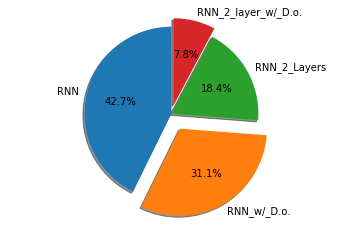

In [45]:
explode = (0., 0.2, 0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [46]:
predictions_05_18 = []
for zipcode in df_time_series.columns:
    predictions_05_18.append(best_model_dict[zipcode][1])

In [47]:
len(predictions_05_18)

103

Adding our best predictions to the Nevada DataFrame

In [48]:
df_time_series.loc['2018-05-01_pred'] = predictions_05_18


/Users/ferityikar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [49]:
df_time_series

,95804,95817,95813,95785,95819,95770,95806,95790,95799,95844,...,95919,95794,399666,95760,95916,95891,95820,95917,95893,95851
1996-04-01 00:00:00,102500.000000,106800.000000,165100.00000,185700.000,144000.00000,122800.000000,95800.000000,148000.00,118900.0,157300.0000,...,116800.0000,170900.00000,196000.00000,153200.00000,184200.00000,299200.0,166100.0000,293200.000000,562400.000,176400.00000
1996-05-01 00:00:00,102500.000000,107000.000000,164500.00000,186300.000,143500.00000,122800.000000,95800.000000,147800.00,119000.0,156000.0000,...,117000.0000,170800.00000,196000.00000,153700.00000,185000.00000,299600.0,166600.0000,293200.000000,562800.000,176300.00000
1996-06-01 00:00:00,102500.000000,107200.000000,164000.00000,186900.000,143100.00000,122700.000000,95800.000000,147600.00,119000.0,154700.0000,...,117200.0000,170700.00000,195900.00000,154100.00000,185800.00000,299900.0,167300.0000,293200.000000,562700.000,176100.00000
1996-07-01 00:00:00,102600.000000,107400.000000,163500.00000,187400.000,142700.00000,122700.000000,95900.000000,147300.00,119100.0,153500.0000,...,117400.0000,170700.00000,195700.00000,154400.00000,186400.00000,300200.0,167900.0000,293200.000000,562400.000,176000.00000
1996-08-01 00:00:00,102700.000000,107600.000000,163200.00000,187700.000,142400.00000,122700.000000,96100.000000,147100.00,119200.0,152600.0000,...,117600.0000,170700.00000,195400.00000,154700.00000,186900.00000,300500.0,168600.0000,293200.000000,562300.000,175900.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 00:00:00,200700.000000,201500.000000,330700.00000,407300.000,294300.00000,234600.000000,189200.000000,303500.00,243700.0,294100.0000,...,270000.0000,316500.00000,315500.00000,299900.00000,449500.00000,642500.0,317600.0000,201600.000000,2121300.000,350400.00000
2018-02-01 00:00:00,203500.000000,204000.000000,334600.00000,410400.000,297400.00000,237200.000000,191700.000000,306700.00,246300.0,296900.0000,...,275600.0000,319500.00000,319500.00000,302500.00000,450100.00000,653800.0,323400.0000,207000.000000,2153600.000,353000.00000
2018-03-01 00:00:00,206600.000000,206700.000000,338800.00000,413700.000,300200.00000,239800.000000,194500.000000,309800.00,249500.0,299400.0000,...,282100.0000,322400.00000,323600.00000,305700.00000,451100.00000,666000.0,334700.0000,216500.000000,2167100.000,356000.00000
2018-04-01 00:00:00,209300.000000,208600.000000,342000.00000,416100.000,302400.00000,241900.000000,196600.000000,312200.00,252000.0,300800.0000,...,286000.0000,324700.00000,326600.00000,307800.00000,455300.00000,672600.0,344300.0000,222800.000000,2161900.000,357200.00000


In [50]:
investment_return = {}
for i in df_time_series.columns:
    investment_return[i] = (df_time_series[i][-1]-df_time_series[i][-2])/df_time_series[i][-2]

In [51]:
investment_return = dict(sorted(investment_return.items(), key=lambda item: item[1]))
investment_return


{95804: -0.6403122760391782,
 95803: -0.6295452663098878,
 95798: -0.6177195348173516,
 95806: -0.613572569621058,
 95817: -0.6031069481064237,
 95815: -0.6021977891515408,
 95800: -0.5948574640287769,
 95852: -0.5884373090786901,
 95771: -0.5782642070244328,
 95811: -0.575701083096591,
 95935: -0.5719107350572655,
 95931: -0.5607943078769559,
 95816: -0.5581633064516129,
 95909: -0.550528379085293,
 95799: -0.5462698412698412,
 95818: -0.5440211504683841,
 95770: -0.5397022917527904,
 95911: -0.5375475456254586,
 95754: -0.5333307904045437,
 95914: -0.5286932394509062,
 95932: -0.5247488011766602,
 399671: -0.5232312362030905,
 95826: -0.5208139675414365,
 95912: -0.5185951487897879,
 95788: -0.517139953337104,
 95792: -0.51701,
 95838: -0.5127071126302083,
 95805: -0.510909343872623,
 95917: -0.5095348266382406,
 95753: -0.50763468141516,
 95814: -0.5049538404726736,
 95841: -0.5032503730959242,
 95940: -0.5021531142334195,
 95843: -0.5010366631120178,
 95795: -0.49936690532652317,
 

In [52]:
list = []
for i in investment_return.keys():
    list.append(i)
best_5_investments = list[-5:]

In [53]:
best_5_investments

[95744, 95750, 95839, 95861, 95938]

In [54]:
investment_chart_data = df_time_series[best_5_investments][-12:]
investment_chart_data

,95744,95750,95839,95861,95938
2017-06-01 00:00:00,281800.00000,236300.0000,244600.00000,255300.00000,400200.00000
2017-07-01 00:00:00,284300.00000,239400.0000,247300.00000,258600.00000,408000.00000
2017-08-01 00:00:00,287000.00000,242400.0000,250700.00000,262000.00000,412500.00000
2017-09-01 00:00:00,290100.00000,245400.0000,255000.00000,265800.00000,415700.00000
2017-10-01 00:00:00,294100.00000,248600.0000,259500.00000,270100.00000,415100.00000
2017-11-01 00:00:00,297300.00000,251300.0000,262500.00000,273500.00000,416500.00000
2017-12-01 00:00:00,300900.00000,254200.0000,265500.00000,276500.00000,419500.00000
2018-01-01 00:00:00,304400.00000,257100.0000,268500.00000,279200.00000,421800.00000
2018-02-01 00:00:00,307500.00000,259500.0000,271700.00000,281700.00000,420600.00000
2018-03-01 00:00:00,310200.00000,261800.0000,275800.00000,283900.00000,418300.00000


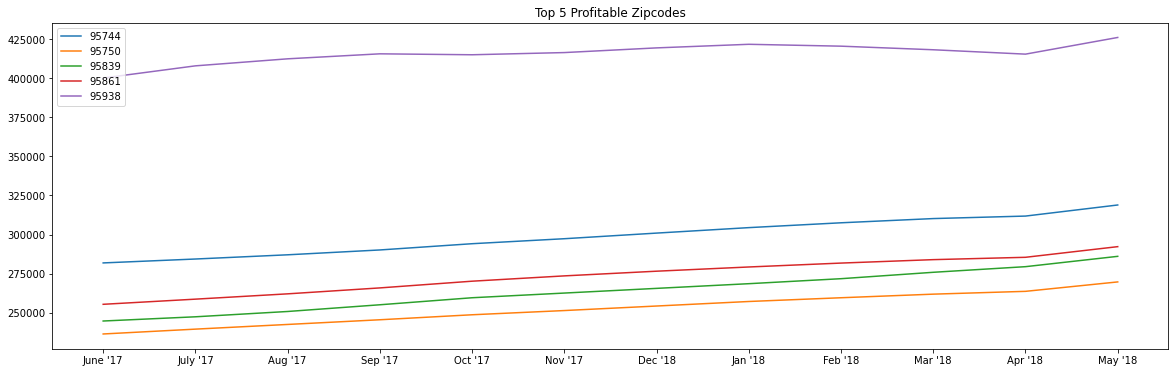

<Figure size 432x288 with 0 Axes>

In [58]:
months = ["June '17", "July '17","Aug '17","Sep '17","Oct '17","Nov '17","Dec '18","Jan '18","Feb '18","Mar '18","Apr '18", "May '18"]
fig, ax = plt.subplots(figsize=(20,6))
fig = plt.figure()

ax.plot(months, investment_chart_data[95744])
ax.plot(months, investment_chart_data[95750])
ax.plot(months, investment_chart_data[95839])
ax.plot(months, investment_chart_data[95861])
ax.plot(months, investment_chart_data[95938])



ax.set_title('Top 5 Profitable Zipcodes')
ax.legend(['95744','95750','95839','95861','95938'], loc=('upper left'));


In [59]:
import pickle

In [60]:
pickle_out = open('rnn_mape.pickle','wb')
pickle.dump(rnn_mape, pickle_out)
pickle_out.close()

In [62]:
pickle_out = open('rnn_dict.pickle','wb')
pickle.dump(rnn_dict, pickle_out)
pickle_out.close()

In [63]:
pickle_out = open('rnn_pred.pickle','wb')
pickle.dump(rnn_pred, pickle_out)
pickle_out.close()

In [64]:
pickle_out = open('rnn_mape2.pickle','wb')
pickle.dump(rnn_mape2, pickle_out)
pickle_out.close()
pickle_out = open('rnn_dict2.pickle','wb')
pickle.dump(rnn_dict2, pickle_out)
pickle_out.close()
pickle_out = open('rnn_pred2.pickle','wb')
pickle.dump(rnn_pred2, pickle_out)
pickle_out.close()

In [65]:
pickle_out = open('rnn_mape3.pickle','wb')
pickle.dump(rnn_mape3, pickle_out)
pickle_out.close()
pickle_out = open('rnn_dict3.pickle','wb')
pickle.dump(rnn_dict3, pickle_out)
pickle_out.close()
pickle_out = open('rnn_pred3.pickle','wb')
pickle.dump(rnn_pred3, pickle_out)
pickle_out.close()

In [66]:
pickle_out = open('rnn_mape4.pickle','wb')
pickle.dump(rnn_mape4, pickle_out)
pickle_out.close()
pickle_out = open('rnn_dict4.pickle','wb')
pickle.dump(rnn_dict4, pickle_out)
pickle_out.close()
pickle_out = open('rnn_pred4.pickle','wb')
pickle.dump(rnn_pred4, pickle_out)
pickle_out.close()